## Using `bracket_builder` to calculate conditional probabilities to feed into R script for viz

In [11]:
import os
import sys
import pandas as pd
from datetime import datetime
import bracket_builder.draw as bb
import bracket_builder.calculate as brac_calc

### Test out drawing standard 64 team bracket

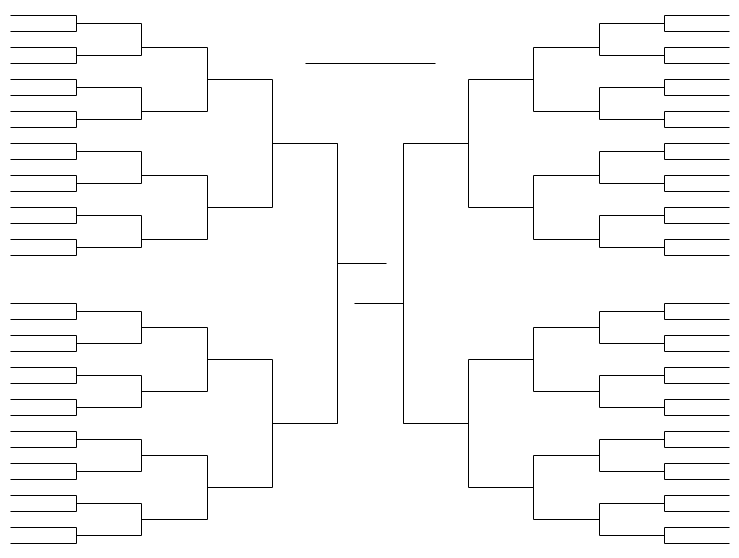

In [2]:
b = bb.Bracket(64)
b.draw_bracket()

### Adding names

In [3]:
os.chdir("../data/women/")

In [4]:
## Get past tournament data to test with
seeds = pd.read_csv("stage_2/WNCAATourneySeeds.csv")
teams = pd.read_csv("stage_2/WTeams.csv")
seeds = seeds.merge(teams[['TeamID', 'TeamName']])
ncaa_slots = pd.read_csv("stage_2/WNCAATourneySlots2022.csv")

In [5]:
def remove_one_playin(ncaa_data):
    
    ### Remove the play-in seed with the seed starting with "b" for now
    #### Would ideally choose the one with the greater win prob. but doesn't matter much
    ncaa_data['seed_endswith_b'] = ncaa_data['Seed'].apply(lambda x: True if x.endswith('b') else False)
    ncaa_data = ncaa_data[~ncaa_data['seed_endswith_b']].copy()
    
    ## Change the Seed for the one starting with a
    ncaa_data['Seed'] = ncaa_data['Seed'].apply(lambda x: x[:-1] if x.endswith('a') else x)
    
    ## Drop the seed_endswith_b column
    ncaa_data = ncaa_data.drop(columns = ['seed_endswith_b'])
    
    return ncaa_data

In [6]:
### Limit to current season
seeds_2022 = seeds[seeds['Season'] == 2022].copy()

## Remove the 'b' play-in seeds and remove 'a' suffix from the deemed 'winner'
seeds_2022 = remove_one_playin(seeds_2022)

## Split the seed into Region and number parts
seeds_2022['seed_num']      = seeds_2022['Seed'].apply(lambda x: int(x[1:]))
seeds_2022['seed_region']   = seeds_2022['Seed'].apply(lambda x: x[0])
seeds_2022['seed_region_2'] = seeds_2022['seed_region'].apply(lambda x: 'Z' if x == 'Y'
                                                               else 'Y' if x == 'Z'
                                                               else x)

## Proper ordering for seeds within each region in the 1st round
seed_order = pd.DataFrame({'seed_num': [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15],
                           'seed_ord': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]})
seeds_2022 = seeds_2022.merge(seed_order)

## Sort it properly and check it out
seeds_2022 = seeds_2022.sort_values(['seed_region_2', 'seed_ord'])
seeds_2022.head(16)

,Season,Seed,TeamID,TeamName,seed_num,seed_region,seed_region_2,seed_ord
8,2022,W01,3301,NC State,1,W,W,1
39,2022,W16,3255,Longwood,16,W,W,2
19,2022,W08,3450,Washington St,8,W,W,3
56,2022,W09,3243,Kansas St,9,W,W,4
24,2022,W05,3323,Notre Dame,5,W,W,5
33,2022,W12,3269,Massachusetts,12,W,W,6
6,2022,W04,3328,Oklahoma,4,W,W,7
55,2022,W13,3237,IUPUI,13,W,W,8
14,2022,W06,3246,Kentucky,6,W,W,9
50,2022,W11,3343,Princeton,11,W,W,10


In [7]:
## Get submission for round 2
subs_path = "subs/submission_probs_2022-03-15.csv"
sub = pd.read_csv(subs_path)
sub['Season'] = sub['ID'].apply(lambda x: x.split('_')[0]).astype(int)
sub['TeamID_1']  = sub['ID'].apply(lambda x: x.split('_')[1]).astype(int)
sub['TeamID_2']  = sub['ID'].apply(lambda x: x.split('_')[2]).astype(int)

## Merge team 1 name
teams = teams.rename(columns={'TeamName': 'TeamName_1',
                              'TeamID': 'TeamID_1'})
teams = teams[['TeamName_1', 'TeamID_1']]
sub = sub.merge(teams, on='TeamID_1', how='left')

## Merge team 2 name
teams = teams.rename(columns={'TeamName_1': 'TeamName_2',
                              'TeamID_1': 'TeamID_2'})
sub = sub.merge(teams, on='TeamID_2', how='left')

sub.head()

,ID,Pred,Season,TeamID_1,TeamID_2,TeamName_1,TeamName_2
0,2022_3107_3110,0.471383,2022,3107,3110,SUNY Albany,American Univ
1,2022_3107_3112,0.069459,2022,3107,3112,SUNY Albany,Arizona
2,2022_3110_3112,0.077241,2022,3110,3112,American Univ,Arizona
3,2022_3107_3116,0.248540,2022,3107,3116,SUNY Albany,Arkansas
4,2022_3110_3116,0.270552,2022,3110,3116,American Univ,Arkansas


In [8]:
round_by_round_probs_df = brac_calc.compute_conditional_probs(subs_path, league = 'women', season = 2022)

round_by_round_probs_df.sort_values('Champ', ascending = False).head(20)

,TeamName,TeamID,Round1,Round2,Sweet16,Elite8,Final4,Final,Champ
55,South Carolina,3376,1.0,0.986840,0.914234,0.710067,0.516608,0.330594,0.195347
45,NC State,3301,1.0,0.983009,0.909598,0.752894,0.473071,0.294784,0.169724
58,Stanford,3390,1.0,0.981925,0.873147,0.663696,0.441873,0.237254,0.130008
35,Louisville,3257,1.0,0.972654,0.819263,0.647162,0.407389,0.226481,0.121086
9,Connecticut,3163,1.0,0.961669,0.796668,0.610613,0.338296,0.201384,0.110147
4,Baylor,3124,1.0,0.971566,0.797645,0.522403,0.291001,0.147637,0.071508
60,Texas,3400,1.0,0.945689,0.780265,0.500023,0.247081,0.108510,0.048717
27,Iowa,3234,1.0,0.963024,0.772394,0.478290,0.196222,0.091406,0.037740
28,Iowa St,3235,1.0,0.938440,0.680047,0.351981,0.127522,0.052806,0.019137
33,LSU,3261,1.0,0.875549,0.613942,0.310111,0.132876,0.049714,0.019009


In [12]:
round_by_round_probs_df.to_csv(f"viz-files/round-by-round-probs-{datetime.today().strftime('%Y-%m-%d')}.csv",
                               index = False)

### Plot what it predicts!


In [ ]:
### Label team names (note: had to switch 'Z' and 'Y' region labels.)
b_2 = bb.Bracket(n_teams = 64, team_names = list(seeds_2021['TeamName']))
b_2.draw_bracket()
b_2.label_teams()

## To-Do

  1. Fix up the `label_winners()` function and/or get a pipeline to easily get winners in required order
  2. Complete the `draw_weighted_lines()` function to draw lines in the team's colors.
  3. Get a pipeline in `calculate` going to `compute_conditional_probs()` in a way that works seamlessly with weighted lines.